In [2]:
from IPython.display import HTML

HTML("""<style>
.lev1 {margin-left: 80px}
.lev2 {margin-left: 100px}
.lev3 {margin-left: 120px}
.lev4 {margin-left: 140px}
.lev5 {margin-left: 160px}
.lev6 {margin-left: 180px}
</style>""")

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Build-the-network" data-toc-modified-id="Build-the-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build the network</a></div><div class="lev2 toc-item"><a href="#Loading-and-cleaning-the-full-dataset" data-toc-modified-id="Loading-and-cleaning-the-full-dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading and cleaning the full dataset</a></div><div class="lev3 toc-item"><a href="#Methodological-note" data-toc-modified-id="Methodological-note-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Methodological note</a></div><div class="lev2 toc-item"><a href="#Build-the-graph" data-toc-modified-id="Build-the-graph-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Build the graph</a></div><div class="lev2 toc-item"><a href="#Draw-the-graph" data-toc-modified-id="Draw-the-graph-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Draw the graph</a></div><div class="lev1 toc-item"><a href="#Network-statistics" data-toc-modified-id="Network-statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Network statistics</a></div>

<center>
<big><b>

Runner's Network analysis on full dataset 

</b></big>
</center>

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import powerlaw 
import networkx as nx

# Build the network 

We construct the runners' network where the _vertex are runners_ and links' weight are the __number of events the participate together__.

## Loading and cleaning the full dataset

In [22]:
full_df = pd.read_pickle('../../df_userID.pickle')
full_df.head(3)

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


### Methodological note

Even if there are few athelets that run more competition the same day, we assume we can neglet the case in which more than 1 runner does that, such that the links weights are not affected.   
With this assumption we can keep only the `RaceId`, as it's string that contraing already the _name and date_ of the race.

Removing useless features

In [23]:
full_df.drop(['MinTemp','MaxTemp','Weather',
              'LivingPlace','Rank','Category','Name',
              'Race','Date','RaceYear','RaceMonth','Place'],axis=1,inplace=True)
full_df.head(3)

,Distance,Sex,Year,Time,Pace,RaceID,UserID
0,15.0,M,1974.0,01:02:25,00:04:09,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,15.0,M,1964.0,00:55:11.700000,00:03:40,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,15.0,M,1947.0,01:12:42.900000,00:04:50,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


## Build the graph

In [28]:
num_nodes = full_df.UserID.nunique()
print('number of vertices:',num_nodes)

number of vertices: 531426


In [83]:
import itertools as itt

Define graph and add __nodes__:

In [174]:
runner_graph = nx.Graph() # define graph
runner_graph.add_nodes_from(nodes_dict.keys()) # add nodes

make a dictionary for nodes' names/index:

In [175]:
nodes_dict = dict.fromkeys(full_df.UserID.unique()[:100])

for n,item in enumerate(nodes_dict.items()):
    nodes_dict[item[0]] = n

add __edges__:

In [ ]:
%%time
# my_adj_mat = np.empty([num_nodes,num_nodes])

for c in itt.combinations(nodes_dict.keys(),2):
        
    c0_races = full_df[full_df.UserID==c[0]].RaceID.unique()
    c1_races = full_df[full_df.UserID==c[1]].RaceID.unique()
    n_shared_race = len(set(c0_races) & set(c1_races))
#     print('# shared rances between',c[0],c[1],'=',n_shared_race)
    
    if n_shared_race!=0:
#         nodes_dict[c[0]].update({c[1]: {'weight':n_shared_race}})

        runner_graph.add_edge(c[0],c[1],weight = n_shared_race)

## Draw the graph

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotl

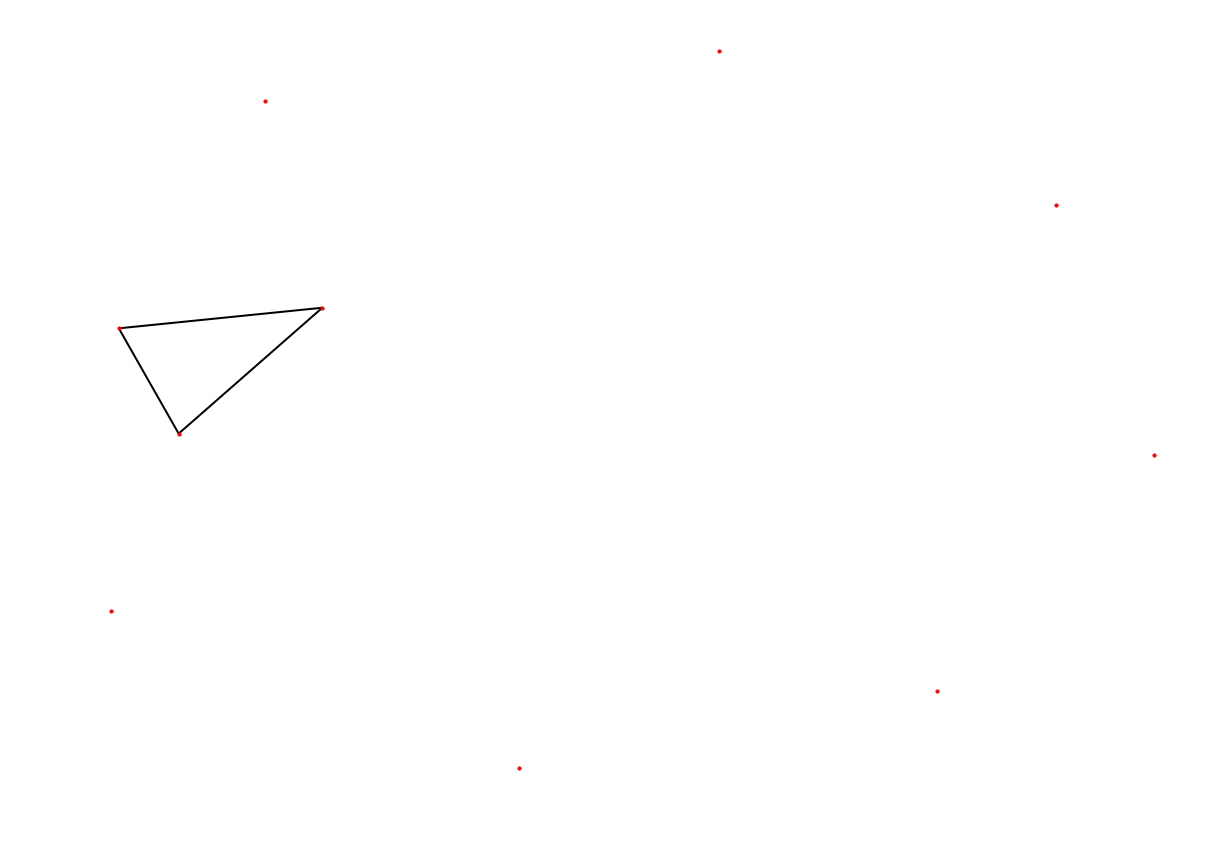

In [173]:
nx.draw_spring(runner_graph,node_size=3)

# Network statistics 